In [2]:
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [3]:
num_h = 64

time_window = total_time

tau_m = 'log-uniform-st'

snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)

In [4]:
print("vanilla feedforward SNN")
a, b = snn_vf.test(test_loader)
print("multifeedforward SNN")
a, b = snn_f.test(test_loader)
print("RNN SNN")
a, b = snn_rnn.test(test_loader)
print("delayed SNN")
a, b = snn_rd.test(test_loader)

vanilla feedforward SNN
2264
Test Loss: 24.178723017374676
Avg spk_count per neuron for all 50 time-steps 359.62941696113074
Test Accuracy of the model on the test samples: 6.758

multifeedforward SNN
2264
Test Loss: 14.634428342183432
Avg spk_count per neuron for all 50 time-steps 378.45494699646645
Test Accuracy of the model on the test samples: 2.739

RNN SNN
2264
Test Loss: 9.70146910349528
Avg spk_count per neuron for all 50 time-steps 373.74734982332154
Test Accuracy of the model on the test samples: 4.373

delayed SNN
2264
Test Loss: 16.746676762898762
Avg spk_count per neuron for all 50 time-steps 453.7988074204947
Test Accuracy of the model on the test samples: 4.814



Vanilla feedforward

tensor(0.0378, device='cuda:0')
tensor(0.1250, device='cuda:0')
tensor(0.1248, device='cuda:0')


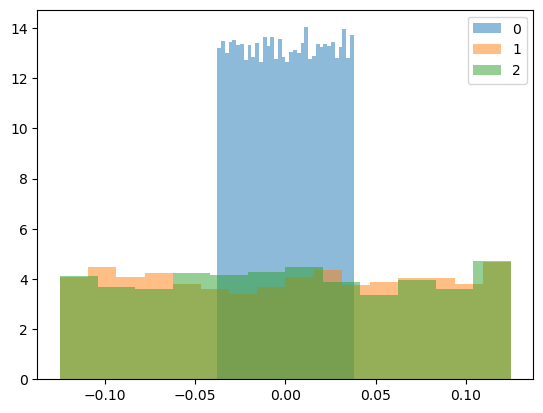

In [5]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_vf.layers):
    plot_param(p.linear, label=i)
    print(p.linear.weight.data.max())
plt.legend()

In [6]:
0.1250/0.0378

3.306878306878307

In [7]:
np.sqrt(700/64)

3.307189138830738

Multi Feedforward

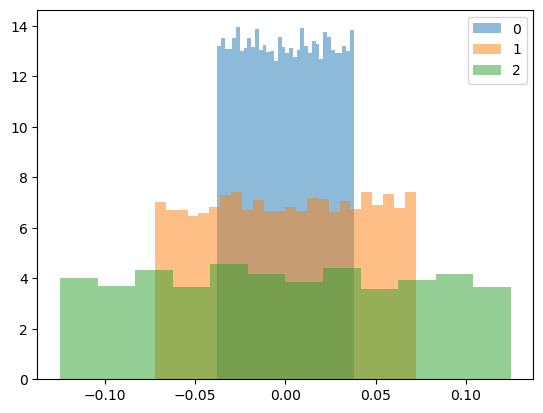

In [8]:
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_f.layers):
    plot_param(p.linear, label=i)
plt.legend()

Delays (random mask)

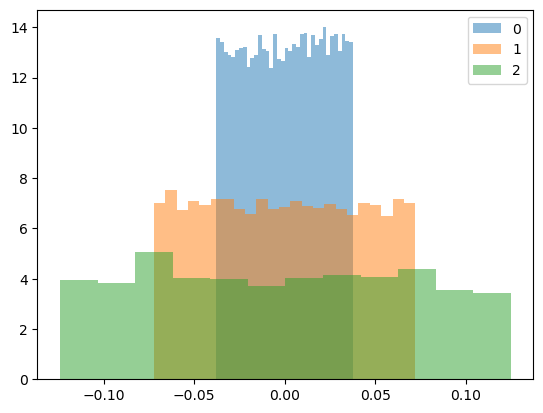

In [10]:
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_rd.layers):
    plot_param(p.linear, label=i, mode='histogram_nonzero')
plt.legend()

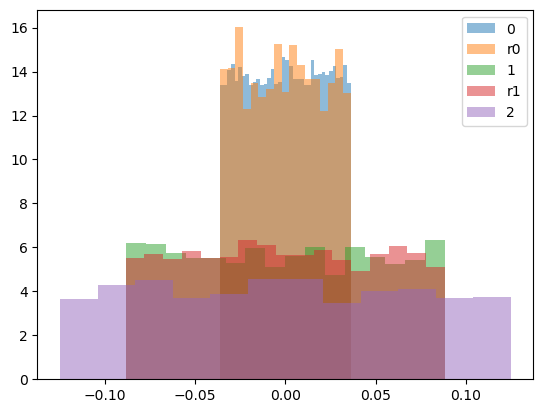

In [11]:
from snn_delays.utils.visualization_utils import plot_param
for i, p in enumerate(snn_rnn.layers[:-1]):
    plot_param(p.linear, label=i)
    plot_param(p.linear_rec, label='r'+str(i))
plot_param(snn_rnn.layers[-1].linear, label=2)
plt.legend()